In [11]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='INFO')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

![module](https://img.shields.io/badge/module-vca-yellow) ![status](https://img.shields.io/badge/status-work%20in%20progress-orange)

## *zwischenwert*

<a href="https://photos.app.goo.gl/pg6iZUC32rTKX5LC7"><img src="https://spielhuus.github.io/elektrophon/images/kontrast-logo-tmb.jpg" height="300px" align="right"></a>

***table of contents***

* [*about*](#about)
* [*construction*](#construction)
* [*calibration*](#calibration)
* [*usage*](#usage)
* [*credits*](#credits)
* [*links*](#links)
* [*changelog*](#changelog)
  
<br/><br/><br/><br/>

## *about*


In [12]:
#load the diffpair schema
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

In [13]:
#simulate diffpair with envelope

class VoltageDivider1(SubCircuitFactory):
    __name__ = 'voltage_divider_1'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

class VoltageDivider2(SubCircuitFactory):
    __name__ = 'voltage_divider_2'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

scanner = parser.build_circuit(ground=5)
scanner.include(spice_library['q2n3906'])
scanner.include(spice_library['D1N4148'])
scanner.include(spice_library['TL072'])
#scanner.include(spice_library['TL072c'])
for subcircuit in (VoltageDivider1(R=200@u_Ω, w=0.0000001), VoltageDivider2(R=100@u_kΩ, w=0.5)) :
    scanner.subcircuit(subcircuit)
for q in (scanner.Q4, scanner.Q5, scanner.Q6, scanner.Q9 ) :
    q.collector.add_current_probe(scanner)

scanner.V('1', '+15V', scanner.gnd, 'DC 12')
scanner.V('2', '-15V', scanner.gnd, 'DC -12')
scanner.V('3', 'CV_IN', scanner.gnd, 'DC 0V AC 0V PULSE(-5 5 0 0m 10m 1u 10m)')
simulator = scanner.simulator(temperature=25, nominal_temperature=25)
analysis_scanner = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=20@u_ms)


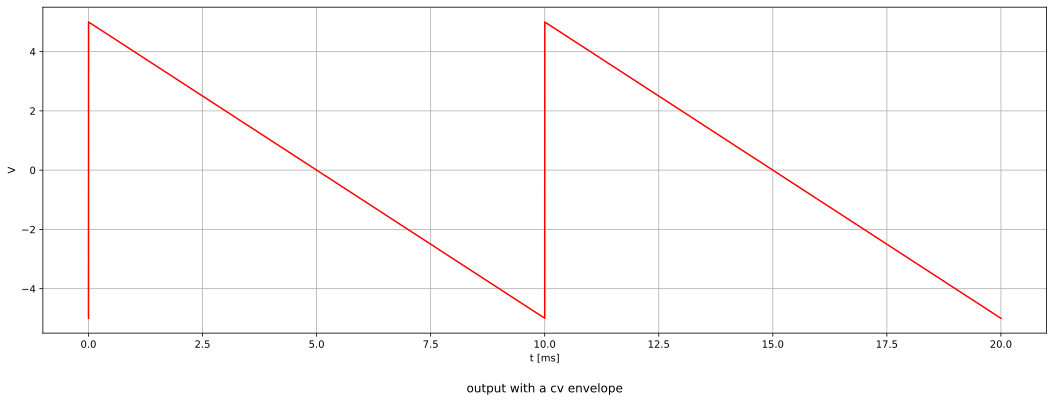

In [18]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(u_ms(analysis_scanner['CV_IN'].abscissa), analysis_scanner['CV_IN'], c='Red')  # envelope input
#ax0.plot(u_ms(analysis_scanner['Net-_D2-Pad2_'].abscissa), analysis_scanner['Net-_D2-Pad2_'], c='Green')  # envelope input (buffered)
#ax0.plot(u_ms(analysis_scanner['vq4_collector'].abscissa), u_uA(-analysis_scanner['vq4_collector'] ), c='Red')  # envelope input (buffered)
#ax0.plot(u_ms(analysis_scanner['vq4_collector'].abscissa), u_uA(-analysis_scanner['vq4_collector'] ), c='Green')  # envelope input (buffered)
#ax0.plot(u_ms(analysis_scanner['vq4_collector'].abscissa), u_uA(-analysis_scanner['vq4_collector'] ), c='Blue')  # envelope input (buffered)
#ax0.plot(u_ms(analysis_scanner['Net-_Q9-Pad3_'].abscissa), u_uA(-analysis_scanner['vq4_collector'] ), c='Magenta')  # envelope input (buffered)

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('V')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

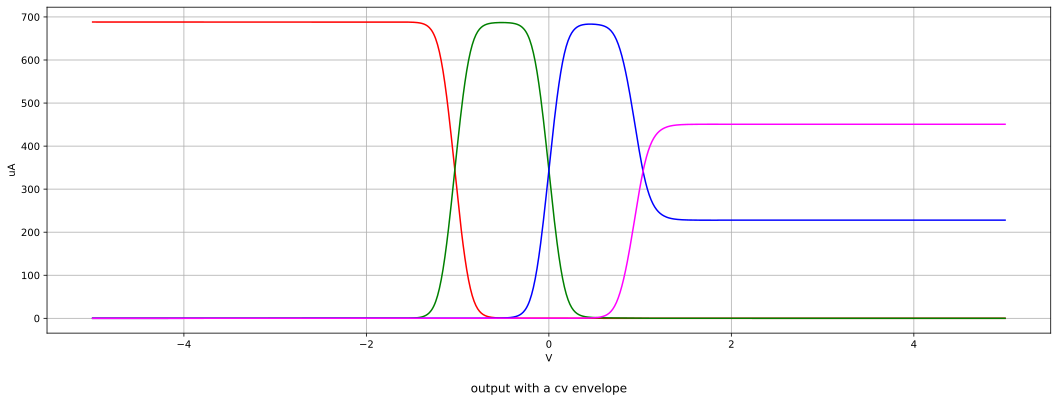

In [15]:
analysis_dc_scanner = simulator.dc(V3=slice(-5, 5, .01))

#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq4_collector'] ), c='Red')  # envelope input (scaled)
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq5_collector'] ), c='Green')  # envelope input (scaled)
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq6_collector'] ), c='Blue')  # envelope input (scaled)
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq9_collector'] ), c='Magenta')  # envelope input (scaled)

ax0.grid()
ax0.set_xlabel('V')
ax0.set_ylabel('uA')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

## *construction*

for the final circuit input and output buffering and biasing is needed. the buffering is done with opamps. 


first we design the input stage. the input voltage for the X signal should be 10mV and 20mV for the control voltage.


## *references*

- [VCA Techniques Investigated][1] Rod Elliott (ESP)
- [Popular Electronics][2] Keyiing and VCA citcuits for electronic music instruments 
- [VCA-1][3] Thomas Henry CA3080 vca
- [VCA-3][4] René Schmitz differential pair vca
- [#223][5]: Basics of the Gilbert Cell | Analog Multiplier | Mixer | Modulator
- [#224][6]: AM & DSB-SC Modulation with the Gilbert Cell
- [Analog Devices][8]: Analog multiplier application guide 
- [AD633][9]: Datasheet 


[1]: https://sound-au.com/articles/vca-techniques.html
[2]: https://tinaja.com/glib/pop_elec/mus_keying_vca_1+2_75.pdf
[3]: https://www.birthofasynth.com/Thomas_Henry/Pages/VCA-1.html
[4]: https://www.schmitzbits.de/vca3.png
[5]: https://www.youtube.com/watch?v=7nmmb0pqTU0&t=2s
[6]: https://www.youtube.com/watch?v=38OQub2Vi2Q
[7]: http://www.ecircuitcenter.com/Circuits/BJT_Diffamp1/BJT_Diffamp1.htm
[8]: https://www.analog.com/media/en/training-seminars/design-handbooks/ADI_Multiplier_Applications_Guide.pdf
[9]: https://www.analog.com/media/en/technical-documentation/data-sheets/AD633.pdf



